In [1]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        return load_train, load_test
    

df = FetchDataset(dataset="CIFAR10", batch_size=128)
df.dataAugmentation(size=32, padding=4)
df.addNormalizer()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:03<00:00, 45208956.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [2]:

import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():

    B=[3,3,2,3]
    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
model = project1_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


In [5]:
EPOCHS=300
globalBestAccuracy = 0.0
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

loss_function = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.001
weightDecay = 0.0001
optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [6]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

def test(model,loader):
    return model.eval() 

def getLoss(loader,model,optimizer):
    running_loss = 0.0
    running_correct = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = loss_function(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(predicted_labels == labels).float().item()
        if phase == "train":
            loss.backward()
            optimizer.step()
    return running_loss,running_correct

for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model,optimzier= train(model,loader,optimizer)
        else:
            loader = testLoader
            model=test(model,loader)
        running_loss,running_correct = getLoss(loader,model,optimizer)
        epoch_loss = running_loss/len(loader.dataset)
        epoch_acc = running_correct/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        else:
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc) 
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))

  0%|          | 1/300 [01:05<5:24:32, 65.12s/it]

Training Loss : 1.6634097966003418, Testing Loss : 1.4657971590042114, Training Accuracy : 0.39648, Testing Accuracy : 0.4737


  1%|          | 2/300 [02:00<4:54:08, 59.22s/it]

Training Loss : 1.331360272064209, Testing Loss : 1.2630615425109863, Training Accuracy : 0.52252, Testing Accuracy : 0.5589


  1%|          | 3/300 [02:55<4:43:13, 57.22s/it]

Training Loss : 1.175146026916504, Testing Loss : 1.173646743774414, Training Accuracy : 0.58058, Testing Accuracy : 0.5912


  1%|▏         | 4/300 [03:50<4:37:56, 56.34s/it]

Training Loss : 1.0813460232543946, Testing Loss : 1.126040905380249, Training Accuracy : 0.61654, Testing Accuracy : 0.6058


  2%|▏         | 5/300 [04:45<4:34:45, 55.88s/it]

Training Loss : 1.0224917213439941, Testing Loss : 1.098470296382904, Training Accuracy : 0.63592, Testing Accuracy : 0.6206


  2%|▏         | 6/300 [05:38<4:30:25, 55.19s/it]

Training Loss : 0.9379803126525879, Testing Loss : 0.9792054696083069, Training Accuracy : 0.67144, Testing Accuracy : 0.6609


  2%|▏         | 7/300 [06:33<4:28:04, 54.90s/it]

Training Loss : 0.8731393472290039, Testing Loss : 0.9525914005279541, Training Accuracy : 0.6907, Testing Accuracy : 0.6677


  3%|▎         | 8/300 [07:28<4:28:25, 55.15s/it]

Training Loss : 0.8390132279968262, Testing Loss : 0.8678206480026245, Training Accuracy : 0.704, Testing Accuracy : 0.7013


  3%|▎         | 9/300 [08:23<4:27:16, 55.11s/it]

Training Loss : 0.782151092376709, Testing Loss : 0.8824191246032714, Training Accuracy : 0.7257, Testing Accuracy : 0.701


  3%|▎         | 10/300 [09:19<4:26:53, 55.22s/it]

Training Loss : 0.7469822412109375, Testing Loss : 0.8167402542114258, Training Accuracy : 0.74042, Testing Accuracy : 0.7172


  4%|▎         | 11/300 [10:15<4:26:37, 55.35s/it]

Training Loss : 0.7089837676239014, Testing Loss : 0.8209729815483093, Training Accuracy : 0.75276, Testing Accuracy : 0.7202


  4%|▍         | 12/300 [11:09<4:23:51, 54.97s/it]

Training Loss : 0.6728977707672119, Testing Loss : 0.7406360407829284, Training Accuracy : 0.76514, Testing Accuracy : 0.7484


  4%|▍         | 13/300 [12:04<4:22:51, 54.95s/it]

Training Loss : 0.6417730986785889, Testing Loss : 0.7138676287651062, Training Accuracy : 0.77438, Testing Accuracy : 0.7554


  5%|▍         | 14/300 [13:00<4:23:22, 55.25s/it]

Training Loss : 0.6121454234313964, Testing Loss : 0.7005439907073975, Training Accuracy : 0.78666, Testing Accuracy : 0.7606


  5%|▌         | 15/300 [13:55<4:22:05, 55.18s/it]

Training Loss : 0.5931573944854737, Testing Loss : 0.6960706784248352, Training Accuracy : 0.79152, Testing Accuracy : 0.7607


  5%|▌         | 16/300 [14:49<4:20:10, 54.96s/it]

Training Loss : 0.5780389443969727, Testing Loss : 0.6738748468399048, Training Accuracy : 0.79978, Testing Accuracy : 0.7739


  6%|▌         | 17/300 [15:43<4:17:44, 54.65s/it]

Training Loss : 0.5660930139160156, Testing Loss : 0.7072031889915467, Training Accuracy : 0.80242, Testing Accuracy : 0.7611


  6%|▌         | 18/300 [16:38<4:17:44, 54.84s/it]

Training Loss : 0.5514001462554932, Testing Loss : 0.7042128556251526, Training Accuracy : 0.80808, Testing Accuracy : 0.7631


  6%|▋         | 19/300 [17:34<4:17:42, 55.03s/it]

Training Loss : 0.5209877094268799, Testing Loss : 0.6327967483520508, Training Accuracy : 0.8183, Testing Accuracy : 0.7832


  7%|▋         | 20/300 [18:29<4:16:56, 55.06s/it]

Training Loss : 0.49266345245361326, Testing Loss : 0.6723048830986023, Training Accuracy : 0.82824, Testing Accuracy : 0.7769


  7%|▋         | 21/300 [19:24<4:16:17, 55.12s/it]

Training Loss : 0.4872576052093506, Testing Loss : 0.6199368582725525, Training Accuracy : 0.83112, Testing Accuracy : 0.7914


  7%|▋         | 22/300 [20:19<4:15:21, 55.11s/it]

Training Loss : 0.4660110926818848, Testing Loss : 0.6178784000873566, Training Accuracy : 0.83838, Testing Accuracy : 0.7954


  8%|▊         | 23/300 [21:13<4:12:36, 54.72s/it]

Training Loss : 0.45859314949035646, Testing Loss : 0.6230661844730377, Training Accuracy : 0.84192, Testing Accuracy : 0.7912


  8%|▊         | 24/300 [22:07<4:11:24, 54.65s/it]

Training Loss : 0.44571593975067136, Testing Loss : 0.5948691974639893, Training Accuracy : 0.8446, Testing Accuracy : 0.8064


  8%|▊         | 25/300 [23:02<4:10:24, 54.63s/it]

Training Loss : 0.43137680603027345, Testing Loss : 0.5901523431777954, Training Accuracy : 0.84928, Testing Accuracy : 0.8022


  9%|▊         | 26/300 [23:57<4:09:23, 54.61s/it]

Training Loss : 0.42123089111328127, Testing Loss : 0.5835400115489959, Training Accuracy : 0.8522, Testing Accuracy : 0.8105


  9%|▉         | 27/300 [24:52<4:09:48, 54.90s/it]

Training Loss : 0.4085746075820923, Testing Loss : 0.5670706110000611, Training Accuracy : 0.85726, Testing Accuracy : 0.8102


  9%|▉         | 28/300 [25:47<4:08:43, 54.87s/it]

Training Loss : 0.3863099742126465, Testing Loss : 0.5744995496749878, Training Accuracy : 0.8647, Testing Accuracy : 0.8128


 10%|▉         | 29/300 [26:41<4:06:14, 54.52s/it]

Training Loss : 0.38450520595550536, Testing Loss : 0.5536337309837341, Training Accuracy : 0.86678, Testing Accuracy : 0.8123


 10%|█         | 30/300 [27:36<4:05:46, 54.62s/it]

Training Loss : 0.36973008392333984, Testing Loss : 0.5561463928699494, Training Accuracy : 0.87046, Testing Accuracy : 0.8177


 10%|█         | 31/300 [28:31<4:06:23, 54.96s/it]

Training Loss : 0.3576688427734375, Testing Loss : 0.5579836532592773, Training Accuracy : 0.87598, Testing Accuracy : 0.8201


 11%|█         | 32/300 [29:26<4:05:50, 55.04s/it]

Training Loss : 0.3491461152267456, Testing Loss : 0.5426459338188171, Training Accuracy : 0.8789, Testing Accuracy : 0.8204


 11%|█         | 33/300 [30:22<4:05:12, 55.10s/it]

Training Loss : 0.33299754451751706, Testing Loss : 0.5470218428611755, Training Accuracy : 0.88462, Testing Accuracy : 0.8255


 11%|█▏        | 34/300 [31:15<4:02:20, 54.67s/it]

Training Loss : 0.3317393469238281, Testing Loss : 0.5677641306877136, Training Accuracy : 0.8839, Testing Accuracy : 0.818


 12%|█▏        | 35/300 [32:10<4:01:24, 54.66s/it]

Training Loss : 0.3326792046737671, Testing Loss : 0.5474146524906158, Training Accuracy : 0.88314, Testing Accuracy : 0.8257


 12%|█▏        | 36/300 [33:04<4:00:04, 54.56s/it]

Training Loss : 0.3164576287841797, Testing Loss : 0.5289728717803955, Training Accuracy : 0.88944, Testing Accuracy : 0.8284


 12%|█▏        | 37/300 [33:59<3:59:22, 54.61s/it]

Training Loss : 0.30089768377304077, Testing Loss : 0.528612475657463, Training Accuracy : 0.89476, Testing Accuracy : 0.8328


 13%|█▎        | 38/300 [34:54<3:59:01, 54.74s/it]

Training Loss : 0.2974096492385864, Testing Loss : 0.5425192601203919, Training Accuracy : 0.89544, Testing Accuracy : 0.8278


 13%|█▎        | 39/300 [35:49<3:57:55, 54.69s/it]

Training Loss : 0.2960149375152588, Testing Loss : 0.5503769578933716, Training Accuracy : 0.89624, Testing Accuracy : 0.8304


 13%|█▎        | 40/300 [36:42<3:55:19, 54.31s/it]

Training Loss : 0.2917054581832886, Testing Loss : 0.5394432043075561, Training Accuracy : 0.89744, Testing Accuracy : 0.8279


 14%|█▎        | 41/300 [37:37<3:54:33, 54.34s/it]

Training Loss : 0.2793454191207886, Testing Loss : 0.5216277693271637, Training Accuracy : 0.90208, Testing Accuracy : 0.8337


 14%|█▍        | 42/300 [38:31<3:54:12, 54.47s/it]

Training Loss : 0.2728107707977295, Testing Loss : 0.5245755690574646, Training Accuracy : 0.90474, Testing Accuracy : 0.8321


 14%|█▍        | 43/300 [39:26<3:53:33, 54.53s/it]

Training Loss : 0.2719124416542053, Testing Loss : 0.5318300727367401, Training Accuracy : 0.90596, Testing Accuracy : 0.8343


 15%|█▍        | 44/300 [40:20<3:52:34, 54.51s/it]

Training Loss : 0.2578336476898193, Testing Loss : 0.5163953810214996, Training Accuracy : 0.90874, Testing Accuracy : 0.8408


 15%|█▌        | 45/300 [41:15<3:51:30, 54.47s/it]

Training Loss : 0.2515429682922363, Testing Loss : 0.5289925957679749, Training Accuracy : 0.91128, Testing Accuracy : 0.8389


 15%|█▌        | 46/300 [42:09<3:50:45, 54.51s/it]

Training Loss : 0.24386968086242675, Testing Loss : 0.5293847995758056, Training Accuracy : 0.91422, Testing Accuracy : 0.8367


 16%|█▌        | 47/300 [43:04<3:49:35, 54.45s/it]

Training Loss : 0.24423806158065797, Testing Loss : 0.5234021947383881, Training Accuracy : 0.91266, Testing Accuracy : 0.8399


 16%|█▌        | 48/300 [43:57<3:47:39, 54.20s/it]

Training Loss : 0.2365262490272522, Testing Loss : 0.5241092436790467, Training Accuracy : 0.91736, Testing Accuracy : 0.8377


 16%|█▋        | 49/300 [44:52<3:46:43, 54.20s/it]

Training Loss : 0.2262022957801819, Testing Loss : 0.5245132851600647, Training Accuracy : 0.92044, Testing Accuracy : 0.8443


 17%|█▋        | 50/300 [45:47<3:47:46, 54.67s/it]

Training Loss : 0.2209707762145996, Testing Loss : 0.534985331106186, Training Accuracy : 0.92092, Testing Accuracy : 0.8402


 17%|█▋        | 51/300 [46:42<3:46:40, 54.62s/it]

Training Loss : 0.2225334832572937, Testing Loss : 0.529205274772644, Training Accuracy : 0.92134, Testing Accuracy : 0.8427


 17%|█▋        | 52/300 [47:36<3:45:29, 54.56s/it]

Training Loss : 0.20938154485702515, Testing Loss : 0.5386268742084503, Training Accuracy : 0.92624, Testing Accuracy : 0.8441


 18%|█▊        | 53/300 [48:29<3:42:57, 54.16s/it]

Training Loss : 0.2071798875617981, Testing Loss : 0.5217710040569306, Training Accuracy : 0.92798, Testing Accuracy : 0.846


 18%|█▊        | 54/300 [49:24<3:42:08, 54.18s/it]

Training Loss : 0.19778082982063294, Testing Loss : 0.5260013820648194, Training Accuracy : 0.93094, Testing Accuracy : 0.8452


 18%|█▊        | 55/300 [50:17<3:40:14, 53.94s/it]

Training Loss : 0.1962147639465332, Testing Loss : 0.5637280011177063, Training Accuracy : 0.93064, Testing Accuracy : 0.839


 19%|█▊        | 56/300 [51:11<3:39:56, 54.08s/it]

Training Loss : 0.1888488426399231, Testing Loss : 0.5196846291542053, Training Accuracy : 0.93404, Testing Accuracy : 0.8522


 19%|█▉        | 57/300 [52:07<3:40:26, 54.43s/it]

Training Loss : 0.18591038633346557, Testing Loss : 0.5369797916531562, Training Accuracy : 0.93504, Testing Accuracy : 0.8465


 19%|█▉        | 58/300 [53:01<3:39:03, 54.31s/it]

Training Loss : 0.18310414974212647, Testing Loss : 0.5278111457347869, Training Accuracy : 0.93514, Testing Accuracy : 0.8505


 20%|█▉        | 59/300 [53:55<3:37:57, 54.26s/it]

Training Loss : 0.17779398529052734, Testing Loss : 0.5367553448200226, Training Accuracy : 0.93742, Testing Accuracy : 0.8461


 20%|██        | 60/300 [54:49<3:37:01, 54.26s/it]

Training Loss : 0.17453572568893433, Testing Loss : 0.5540067034721374, Training Accuracy : 0.9382, Testing Accuracy : 0.8451


 20%|██        | 61/300 [55:43<3:35:11, 54.02s/it]

Training Loss : 0.17494772329330444, Testing Loss : 0.5257687135696412, Training Accuracy : 0.93868, Testing Accuracy : 0.8526


 21%|██        | 62/300 [56:37<3:34:50, 54.16s/it]

Training Loss : 0.1683451989555359, Testing Loss : 0.5394300169944763, Training Accuracy : 0.94142, Testing Accuracy : 0.8519


 21%|██        | 63/300 [57:32<3:34:54, 54.41s/it]

Training Loss : 0.16480523619651793, Testing Loss : 0.5462071246147155, Training Accuracy : 0.94118, Testing Accuracy : 0.8531


 21%|██▏       | 64/300 [58:26<3:33:30, 54.28s/it]

Training Loss : 0.16380702016830445, Testing Loss : 0.532077103638649, Training Accuracy : 0.94064, Testing Accuracy : 0.8553


 22%|██▏       | 65/300 [59:20<3:31:42, 54.05s/it]

Training Loss : 0.15289660130500793, Testing Loss : 0.5629375485420227, Training Accuracy : 0.94636, Testing Accuracy : 0.8503


 22%|██▏       | 66/300 [1:00:13<3:30:07, 53.88s/it]

Training Loss : 0.16369483570098878, Testing Loss : 0.5368133823394775, Training Accuracy : 0.94342, Testing Accuracy : 0.8524


 22%|██▏       | 67/300 [1:01:06<3:28:34, 53.71s/it]

Training Loss : 0.1527710848045349, Testing Loss : 0.5582296815872192, Training Accuracy : 0.9452, Testing Accuracy : 0.8445


 23%|██▎       | 68/300 [1:02:00<3:27:31, 53.67s/it]

Training Loss : 0.15006555031776428, Testing Loss : 0.536513585948944, Training Accuracy : 0.94634, Testing Accuracy : 0.8572


 23%|██▎       | 69/300 [1:02:53<3:26:17, 53.58s/it]

Training Loss : 0.15022572381973268, Testing Loss : 0.5374163287162781, Training Accuracy : 0.94652, Testing Accuracy : 0.8542


 23%|██▎       | 70/300 [1:03:48<3:26:14, 53.80s/it]

Training Loss : 0.14058225276947023, Testing Loss : 0.5480773797988892, Training Accuracy : 0.94928, Testing Accuracy : 0.8556


 24%|██▎       | 71/300 [1:04:42<3:25:51, 53.93s/it]

Training Loss : 0.14117020350456239, Testing Loss : 0.5413650908470153, Training Accuracy : 0.94942, Testing Accuracy : 0.8554


 24%|██▍       | 72/300 [1:05:36<3:25:10, 53.99s/it]

Training Loss : 0.12887839217185973, Testing Loss : 0.5529464786529541, Training Accuracy : 0.95418, Testing Accuracy : 0.853


 24%|██▍       | 73/300 [1:06:29<3:23:23, 53.76s/it]

Training Loss : 0.12815354196548462, Testing Loss : 0.5450408525466919, Training Accuracy : 0.9548, Testing Accuracy : 0.8576


 25%|██▍       | 74/300 [1:07:23<3:22:01, 53.64s/it]

Training Loss : 0.13199727248191834, Testing Loss : 0.5443095335483551, Training Accuracy : 0.95276, Testing Accuracy : 0.852


 25%|██▌       | 75/300 [1:08:16<3:20:48, 53.55s/it]

Training Loss : 0.1287537487411499, Testing Loss : 0.5537992992401123, Training Accuracy : 0.95442, Testing Accuracy : 0.8546


 25%|██▌       | 76/300 [1:09:09<3:19:18, 53.39s/it]

Training Loss : 0.12135365852355957, Testing Loss : 0.5644007308006287, Training Accuracy : 0.95712, Testing Accuracy : 0.8553


 26%|██▌       | 77/300 [1:10:02<3:18:34, 53.43s/it]

Training Loss : 0.12011833233833313, Testing Loss : 0.5639037467956542, Training Accuracy : 0.95706, Testing Accuracy : 0.8575


 26%|██▌       | 78/300 [1:10:57<3:18:52, 53.75s/it]

Training Loss : 0.11389279790401459, Testing Loss : 0.5742175250053406, Training Accuracy : 0.95968, Testing Accuracy : 0.8517


 26%|██▋       | 79/300 [1:11:51<3:18:23, 53.86s/it]

Training Loss : 0.11361781922340393, Testing Loss : 0.5819770005226135, Training Accuracy : 0.9603, Testing Accuracy : 0.8539


 27%|██▋       | 80/300 [1:12:45<3:17:36, 53.89s/it]

Training Loss : 0.11072767890453339, Testing Loss : 0.5563110013008118, Training Accuracy : 0.9616, Testing Accuracy : 0.8582


 27%|██▋       | 81/300 [1:13:39<3:16:25, 53.82s/it]

Training Loss : 0.11078763062477112, Testing Loss : 0.5731430282592773, Training Accuracy : 0.96156, Testing Accuracy : 0.8577


 27%|██▋       | 82/300 [1:14:32<3:15:17, 53.75s/it]

Training Loss : 0.10320395356178284, Testing Loss : 0.5636415135383606, Training Accuracy : 0.96272, Testing Accuracy : 0.8581


 28%|██▊       | 83/300 [1:15:26<3:14:20, 53.73s/it]

Training Loss : 0.09725739791870117, Testing Loss : 0.5723299419403076, Training Accuracy : 0.96642, Testing Accuracy : 0.8561


 28%|██▊       | 84/300 [1:16:21<3:14:41, 54.08s/it]

Training Loss : 0.09656373173713684, Testing Loss : 0.5359154985904694, Training Accuracy : 0.9655, Testing Accuracy : 0.8586


 28%|██▊       | 85/300 [1:17:15<3:14:19, 54.23s/it]

Training Loss : 0.0935833580160141, Testing Loss : 0.5620636772155762, Training Accuracy : 0.9672, Testing Accuracy : 0.8605


 29%|██▊       | 86/300 [1:18:10<3:13:17, 54.19s/it]

Training Loss : 0.09120343703269959, Testing Loss : 0.5529014987945556, Training Accuracy : 0.9684, Testing Accuracy : 0.8602


 29%|██▉       | 87/300 [1:19:04<3:12:15, 54.16s/it]

Training Loss : 0.09378231300830842, Testing Loss : 0.5848484211444854, Training Accuracy : 0.96616, Testing Accuracy : 0.8584


 29%|██▉       | 88/300 [1:19:57<3:10:56, 54.04s/it]

Training Loss : 0.0913191265630722, Testing Loss : 0.5609041742801666, Training Accuracy : 0.96812, Testing Accuracy : 0.8605


 30%|██▉       | 89/300 [1:20:52<3:10:07, 54.06s/it]

Training Loss : 0.0889857717514038, Testing Loss : 0.5676252481937408, Training Accuracy : 0.96862, Testing Accuracy : 0.8616


 30%|███       | 90/300 [1:21:47<3:10:56, 54.55s/it]

Training Loss : 0.08768718035697937, Testing Loss : 0.5921220915317535, Training Accuracy : 0.96916, Testing Accuracy : 0.857


 30%|███       | 91/300 [1:22:42<3:10:17, 54.63s/it]

Training Loss : 0.08240950669288635, Testing Loss : 0.5955799485206604, Training Accuracy : 0.97104, Testing Accuracy : 0.8561


 31%|███       | 92/300 [1:23:36<3:08:53, 54.49s/it]

Training Loss : 0.0794893605709076, Testing Loss : 0.5882809872627258, Training Accuracy : 0.9717, Testing Accuracy : 0.86


 31%|███       | 93/300 [1:24:30<3:07:32, 54.36s/it]

Training Loss : 0.07877135771751403, Testing Loss : 0.5938554535865783, Training Accuracy : 0.97162, Testing Accuracy : 0.8612


 31%|███▏      | 94/300 [1:25:24<3:05:59, 54.17s/it]

Training Loss : 0.0786953644657135, Testing Loss : 0.6003457783222198, Training Accuracy : 0.9718, Testing Accuracy : 0.8587


 32%|███▏      | 95/300 [1:26:18<3:04:39, 54.05s/it]

Training Loss : 0.07985556311607361, Testing Loss : 0.6064901068687439, Training Accuracy : 0.97118, Testing Accuracy : 0.8582


 32%|███▏      | 96/300 [1:27:12<3:03:30, 53.97s/it]

Training Loss : 0.07372391784191132, Testing Loss : 0.5756152582526207, Training Accuracy : 0.97424, Testing Accuracy : 0.8627


 32%|███▏      | 97/300 [1:28:06<3:03:23, 54.21s/it]

Training Loss : 0.0664858630847931, Testing Loss : 0.5815307787418366, Training Accuracy : 0.97686, Testing Accuracy : 0.8635


 33%|███▎      | 98/300 [1:29:01<3:02:39, 54.25s/it]

Training Loss : 0.06142186898469925, Testing Loss : 0.5801712440907956, Training Accuracy : 0.97922, Testing Accuracy : 0.8634


 33%|███▎      | 99/300 [1:29:55<3:01:26, 54.16s/it]

Training Loss : 0.06354901727199555, Testing Loss : 0.5911518187046051, Training Accuracy : 0.97786, Testing Accuracy : 0.8611


 33%|███▎      | 100/300 [1:30:48<3:00:07, 54.04s/it]

Training Loss : 0.06086058004260063, Testing Loss : 0.622785729265213, Training Accuracy : 0.97886, Testing Accuracy : 0.8603


 34%|███▎      | 101/300 [1:31:42<2:58:51, 53.93s/it]

Training Loss : 0.06170539791822433, Testing Loss : 0.5889838970661163, Training Accuracy : 0.97836, Testing Accuracy : 0.8646


 34%|███▍      | 102/300 [1:32:36<2:57:44, 53.86s/it]

Training Loss : 0.06227190457820892, Testing Loss : 0.5951202878952027, Training Accuracy : 0.97836, Testing Accuracy : 0.8673


 34%|███▍      | 103/300 [1:33:31<2:57:58, 54.21s/it]

Training Loss : 0.058780763473510744, Testing Loss : 0.5807655130386352, Training Accuracy : 0.97946, Testing Accuracy : 0.868


 35%|███▍      | 104/300 [1:34:25<2:57:19, 54.28s/it]

Training Loss : 0.05352105331659317, Testing Loss : 0.5919118154525757, Training Accuracy : 0.98166, Testing Accuracy : 0.8675


 35%|███▌      | 105/300 [1:35:19<2:56:11, 54.21s/it]

Training Loss : 0.05532589082717895, Testing Loss : 0.6092600932598115, Training Accuracy : 0.98126, Testing Accuracy : 0.8643


 35%|███▌      | 106/300 [1:36:13<2:54:36, 54.00s/it]

Training Loss : 0.05309079130291939, Testing Loss : 0.603745238161087, Training Accuracy : 0.98126, Testing Accuracy : 0.8656


 36%|███▌      | 107/300 [1:37:06<2:53:23, 53.90s/it]

Training Loss : 0.053215438269376754, Testing Loss : 0.6058806869506836, Training Accuracy : 0.98092, Testing Accuracy : 0.8655


 36%|███▌      | 108/300 [1:38:00<2:52:33, 53.92s/it]

Training Loss : 0.0501368877029419, Testing Loss : 0.6009363217830658, Training Accuracy : 0.98322, Testing Accuracy : 0.8682


 36%|███▋      | 109/300 [1:38:54<2:51:18, 53.81s/it]

Training Loss : 0.04813270542383194, Testing Loss : 0.605047772192955, Training Accuracy : 0.9827, Testing Accuracy : 0.8673


 37%|███▋      | 110/300 [1:39:48<2:50:49, 53.95s/it]

Training Loss : 0.04868185144543648, Testing Loss : 0.6173162674903869, Training Accuracy : 0.98226, Testing Accuracy : 0.8665


 37%|███▋      | 111/300 [1:40:43<2:50:30, 54.13s/it]

Training Loss : 0.04814316094994545, Testing Loss : 0.609543577837944, Training Accuracy : 0.98356, Testing Accuracy : 0.8645


 37%|███▋      | 112/300 [1:41:37<2:49:48, 54.19s/it]

Training Loss : 0.04404183824777603, Testing Loss : 0.6002053948163987, Training Accuracy : 0.98434, Testing Accuracy : 0.8709


 38%|███▊      | 113/300 [1:42:31<2:48:31, 54.07s/it]

Training Loss : 0.044293763948082925, Testing Loss : 0.6136779616355896, Training Accuracy : 0.98424, Testing Accuracy : 0.8655


 38%|███▊      | 114/300 [1:43:24<2:47:06, 53.91s/it]

Training Loss : 0.04964050548553467, Testing Loss : 0.6154330117225647, Training Accuracy : 0.98288, Testing Accuracy : 0.8669


 38%|███▊      | 115/300 [1:44:18<2:45:54, 53.81s/it]

Training Loss : 0.04663488451719284, Testing Loss : 0.6465955256462097, Training Accuracy : 0.98342, Testing Accuracy : 0.8636


 39%|███▊      | 116/300 [1:45:12<2:45:10, 53.86s/it]

Training Loss : 0.04966428292632103, Testing Loss : 0.6158074938774108, Training Accuracy : 0.98264, Testing Accuracy : 0.87


 39%|███▉      | 117/300 [1:46:07<2:45:33, 54.28s/it]

Training Loss : 0.044185427297353745, Testing Loss : 0.6296392551541329, Training Accuracy : 0.9846, Testing Accuracy : 0.8671


 39%|███▉      | 118/300 [1:47:02<2:45:01, 54.40s/it]

Training Loss : 0.04242261610150337, Testing Loss : 0.6144365375518799, Training Accuracy : 0.98514, Testing Accuracy : 0.873


 40%|███▉      | 119/300 [1:47:56<2:44:00, 54.36s/it]

Training Loss : 0.040077978129386904, Testing Loss : 0.6204596382617951, Training Accuracy : 0.98578, Testing Accuracy : 0.8703


 40%|████      | 120/300 [1:48:50<2:42:24, 54.14s/it]

Training Loss : 0.04091988221168518, Testing Loss : 0.6187464456558227, Training Accuracy : 0.98622, Testing Accuracy : 0.8705


 40%|████      | 121/300 [1:49:43<2:40:59, 53.96s/it]

Training Loss : 0.03879216967344284, Testing Loss : 0.6208360984802246, Training Accuracy : 0.98646, Testing Accuracy : 0.872


 41%|████      | 122/300 [1:50:37<2:40:05, 53.96s/it]

Training Loss : 0.03879359712004662, Testing Loss : 0.6147013876438141, Training Accuracy : 0.98622, Testing Accuracy : 0.8717


 41%|████      | 123/300 [1:51:31<2:39:08, 53.95s/it]

Training Loss : 0.03576898479759693, Testing Loss : 0.6168756085634232, Training Accuracy : 0.9881, Testing Accuracy : 0.8699


 41%|████▏     | 124/300 [1:52:26<2:38:48, 54.14s/it]

Training Loss : 0.033561960465312006, Testing Loss : 0.6276326050519944, Training Accuracy : 0.98824, Testing Accuracy : 0.8705


 42%|████▏     | 125/300 [1:53:20<2:38:20, 54.29s/it]

Training Loss : 0.03617044839978218, Testing Loss : 0.6428299350261688, Training Accuracy : 0.98734, Testing Accuracy : 0.8701


 42%|████▏     | 126/300 [1:54:15<2:37:33, 54.33s/it]

Training Loss : 0.03888842258632183, Testing Loss : 0.6420615888118744, Training Accuracy : 0.9863, Testing Accuracy : 0.8687


 42%|████▏     | 127/300 [1:55:09<2:36:06, 54.14s/it]

Training Loss : 0.036874457073807716, Testing Loss : 0.652536670422554, Training Accuracy : 0.98698, Testing Accuracy : 0.8668


 43%|████▎     | 128/300 [1:56:02<2:34:38, 53.95s/it]

Training Loss : 0.03627653599500656, Testing Loss : 0.6378552074432373, Training Accuracy : 0.98814, Testing Accuracy : 0.8707


 43%|████▎     | 129/300 [1:56:56<2:33:27, 53.85s/it]

Training Loss : 0.03647291916489601, Testing Loss : 0.650527855348587, Training Accuracy : 0.98752, Testing Accuracy : 0.8683


 43%|████▎     | 130/300 [1:57:49<2:32:25, 53.80s/it]

Training Loss : 0.03564313077270985, Testing Loss : 0.6377936336517334, Training Accuracy : 0.98772, Testing Accuracy : 0.8703


 44%|████▎     | 131/300 [1:58:43<2:31:44, 53.87s/it]

Training Loss : 0.03308170322537422, Testing Loss : 0.6409351526498794, Training Accuracy : 0.98878, Testing Accuracy : 0.8681


 44%|████▍     | 132/300 [1:59:38<2:31:49, 54.22s/it]

Training Loss : 0.03223662195265293, Testing Loss : 0.6486809104442597, Training Accuracy : 0.98842, Testing Accuracy : 0.8692


 44%|████▍     | 133/300 [2:00:33<2:30:58, 54.24s/it]

Training Loss : 0.030834796434640883, Testing Loss : 0.6568445365905762, Training Accuracy : 0.99024, Testing Accuracy : 0.866


 45%|████▍     | 134/300 [2:01:27<2:29:44, 54.13s/it]

Training Loss : 0.030862524563670158, Testing Loss : 0.6389965012550354, Training Accuracy : 0.98942, Testing Accuracy : 0.8711


 45%|████▌     | 135/300 [2:02:20<2:28:22, 53.95s/it]

Training Loss : 0.03052269193291664, Testing Loss : 0.6538847935676575, Training Accuracy : 0.98978, Testing Accuracy : 0.8687


 45%|████▌     | 136/300 [2:03:14<2:27:20, 53.91s/it]

Training Loss : 0.0328653674864769, Testing Loss : 0.6680650074958802, Training Accuracy : 0.98796, Testing Accuracy : 0.8687


 46%|████▌     | 137/300 [2:04:08<2:26:14, 53.83s/it]

Training Loss : 0.036853540014028546, Testing Loss : 0.6809687255978585, Training Accuracy : 0.9874, Testing Accuracy : 0.8652


 46%|████▌     | 138/300 [2:05:02<2:25:29, 53.89s/it]

Training Loss : 0.03894810312271118, Testing Loss : 0.6752740578174591, Training Accuracy : 0.9865, Testing Accuracy : 0.8673


 46%|████▋     | 139/300 [2:05:56<2:25:21, 54.17s/it]

Training Loss : 0.036638155972361565, Testing Loss : 0.6751920506119728, Training Accuracy : 0.98652, Testing Accuracy : 0.8657


 47%|████▋     | 140/300 [2:06:51<2:24:42, 54.26s/it]

Training Loss : 0.034334809972643855, Testing Loss : 0.6656843020915985, Training Accuracy : 0.98818, Testing Accuracy : 0.8686


 47%|████▋     | 141/300 [2:07:45<2:23:16, 54.06s/it]

Training Loss : 0.03394762060523033, Testing Loss : 0.6829519988894462, Training Accuracy : 0.9884, Testing Accuracy : 0.8658


 47%|████▋     | 142/300 [2:08:38<2:21:51, 53.87s/it]

Training Loss : 0.031428739961385725, Testing Loss : 0.6602584293842315, Training Accuracy : 0.9894, Testing Accuracy : 0.8693


 48%|████▊     | 143/300 [2:09:31<2:20:38, 53.75s/it]

Training Loss : 0.029163893337249756, Testing Loss : 0.6548444613695145, Training Accuracy : 0.98982, Testing Accuracy : 0.8693


 48%|████▊     | 144/300 [2:10:25<2:19:37, 53.70s/it]

Training Loss : 0.027083096605837347, Testing Loss : 0.6439731379508972, Training Accuracy : 0.99046, Testing Accuracy : 0.8753


 48%|████▊     | 145/300 [2:11:19<2:18:52, 53.76s/it]

Training Loss : 0.025947180694043635, Testing Loss : 0.6546971796035767, Training Accuracy : 0.99112, Testing Accuracy : 0.8715


 49%|████▊     | 146/300 [2:12:14<2:18:39, 54.02s/it]

Training Loss : 0.023256180260181426, Testing Loss : 0.6563466935634613, Training Accuracy : 0.99204, Testing Accuracy : 0.873


 49%|████▉     | 147/300 [2:13:08<2:18:04, 54.15s/it]

Training Loss : 0.021772897953391074, Testing Loss : 0.6457645087242126, Training Accuracy : 0.99294, Testing Accuracy : 0.8727


 49%|████▉     | 148/300 [2:14:02<2:17:06, 54.12s/it]

Training Loss : 0.021528914249539375, Testing Loss : 0.6360898675918579, Training Accuracy : 0.99332, Testing Accuracy : 0.8746


 50%|████▉     | 149/300 [2:14:56<2:16:02, 54.05s/it]

Training Loss : 0.0201797807097435, Testing Loss : 0.6480315100669861, Training Accuracy : 0.99344, Testing Accuracy : 0.8747


 50%|█████     | 150/300 [2:15:50<2:14:46, 53.91s/it]

Training Loss : 0.020710846268981696, Testing Loss : 0.6476260773658753, Training Accuracy : 0.99336, Testing Accuracy : 0.8761


 50%|█████     | 151/300 [2:16:43<2:13:46, 53.87s/it]

Training Loss : 0.020055940470397472, Testing Loss : 0.6541544075489044, Training Accuracy : 0.99342, Testing Accuracy : 0.8747


 51%|█████     | 152/300 [2:17:38<2:13:48, 54.25s/it]

Training Loss : 0.021456390671730042, Testing Loss : 0.6571219624042511, Training Accuracy : 0.99308, Testing Accuracy : 0.8711


 51%|█████     | 153/300 [2:18:33<2:13:14, 54.38s/it]

Training Loss : 0.01994332176208496, Testing Loss : 0.6604832069396973, Training Accuracy : 0.9936, Testing Accuracy : 0.8742


 51%|█████▏    | 154/300 [2:19:28<2:12:30, 54.46s/it]

Training Loss : 0.020483030048310757, Testing Loss : 0.6537919001579284, Training Accuracy : 0.99266, Testing Accuracy : 0.8723


 52%|█████▏    | 155/300 [2:20:22<2:11:16, 54.32s/it]

Training Loss : 0.018742375732064248, Testing Loss : 0.6513192140102386, Training Accuracy : 0.99394, Testing Accuracy : 0.8764


 52%|█████▏    | 156/300 [2:21:16<2:10:00, 54.17s/it]

Training Loss : 0.019370715759396553, Testing Loss : 0.6656677769184113, Training Accuracy : 0.9939, Testing Accuracy : 0.8705


 52%|█████▏    | 157/300 [2:22:09<2:08:46, 54.03s/it]

Training Loss : 0.020840081816911698, Testing Loss : 0.6558639519691467, Training Accuracy : 0.99304, Testing Accuracy : 0.8734


 53%|█████▎    | 158/300 [2:23:03<2:07:27, 53.85s/it]

Training Loss : 0.01977352978914976, Testing Loss : 0.6715498184680939, Training Accuracy : 0.9932, Testing Accuracy : 0.8708


 53%|█████▎    | 159/300 [2:23:58<2:07:26, 54.23s/it]

Training Loss : 0.01894443178653717, Testing Loss : 0.6505246647357941, Training Accuracy : 0.99358, Testing Accuracy : 0.8743


 53%|█████▎    | 160/300 [2:24:52<2:06:34, 54.25s/it]

Training Loss : 0.0178708902618289, Testing Loss : 0.6678089661598205, Training Accuracy : 0.99414, Testing Accuracy : 0.8726


 54%|█████▎    | 161/300 [2:25:46<2:05:32, 54.19s/it]

Training Loss : 0.016956063202619553, Testing Loss : 0.6572630437850953, Training Accuracy : 0.99444, Testing Accuracy : 0.8747


 54%|█████▍    | 162/300 [2:26:40<2:04:28, 54.12s/it]

Training Loss : 0.016917480066716672, Testing Loss : 0.6644854595184326, Training Accuracy : 0.99474, Testing Accuracy : 0.8733


 54%|█████▍    | 163/300 [2:27:34<2:03:22, 54.03s/it]

Training Loss : 0.017300822024047376, Testing Loss : 0.6630811868906021, Training Accuracy : 0.99442, Testing Accuracy : 0.8763


 55%|█████▍    | 164/300 [2:28:28<2:02:21, 53.98s/it]

Training Loss : 0.015529712938666344, Testing Loss : 0.6573508197784423, Training Accuracy : 0.99482, Testing Accuracy : 0.8764


 55%|█████▌    | 165/300 [2:29:22<2:01:45, 54.12s/it]

Training Loss : 0.015152827482819558, Testing Loss : 0.6638203194379807, Training Accuracy : 0.99498, Testing Accuracy : 0.8752


 55%|█████▌    | 166/300 [2:30:17<2:01:27, 54.39s/it]

Training Loss : 0.013329202452600003, Testing Loss : 0.6491574716567993, Training Accuracy : 0.99606, Testing Accuracy : 0.8788


 56%|█████▌    | 167/300 [2:31:12<2:00:46, 54.49s/it]

Training Loss : 0.012866846124082804, Testing Loss : 0.6643082023978233, Training Accuracy : 0.99614, Testing Accuracy : 0.8774


 56%|█████▌    | 168/300 [2:32:05<1:59:12, 54.19s/it]

Training Loss : 0.014121755730360746, Testing Loss : 0.6617652391910553, Training Accuracy : 0.99542, Testing Accuracy : 0.879


 56%|█████▋    | 169/300 [2:32:59<1:57:53, 54.00s/it]

Training Loss : 0.012719783585369586, Testing Loss : 0.6533542118310929, Training Accuracy : 0.9957, Testing Accuracy : 0.8778


 57%|█████▋    | 170/300 [2:33:53<1:56:39, 53.84s/it]

Training Loss : 0.012252653136327863, Testing Loss : 0.6650118292808532, Training Accuracy : 0.99606, Testing Accuracy : 0.8786


 57%|█████▋    | 171/300 [2:34:46<1:55:35, 53.76s/it]

Training Loss : 0.012457907685637475, Testing Loss : 0.6509585131645202, Training Accuracy : 0.9964, Testing Accuracy : 0.8788


 57%|█████▋    | 172/300 [2:35:41<1:55:15, 54.02s/it]

Training Loss : 0.01282710207119584, Testing Loss : 0.6543494966983795, Training Accuracy : 0.99618, Testing Accuracy : 0.8801


 58%|█████▊    | 173/300 [2:36:35<1:54:45, 54.22s/it]

Training Loss : 0.011232994972467422, Testing Loss : 0.6671272388935089, Training Accuracy : 0.99652, Testing Accuracy : 0.875


 58%|█████▊    | 174/300 [2:37:30<1:54:03, 54.31s/it]

Training Loss : 0.011681960860788822, Testing Loss : 0.6668196384429932, Training Accuracy : 0.99638, Testing Accuracy : 0.8794


 58%|█████▊    | 175/300 [2:38:24<1:52:41, 54.09s/it]

Training Loss : 0.01114878072693944, Testing Loss : 0.6647149282455445, Training Accuracy : 0.99678, Testing Accuracy : 0.8764


 59%|█████▊    | 176/300 [2:39:17<1:51:29, 53.95s/it]

Training Loss : 0.010510763624608517, Testing Loss : 0.6672215341567993, Training Accuracy : 0.99684, Testing Accuracy : 0.8777


 59%|█████▉    | 177/300 [2:40:11<1:50:22, 53.84s/it]

Training Loss : 0.010039260643571616, Testing Loss : 0.6659490500926971, Training Accuracy : 0.99712, Testing Accuracy : 0.8777


 59%|█████▉    | 178/300 [2:41:04<1:49:18, 53.76s/it]

Training Loss : 0.01196080856397748, Testing Loss : 0.6730166837215423, Training Accuracy : 0.99616, Testing Accuracy : 0.8778


 60%|█████▉    | 179/300 [2:42:00<1:49:35, 54.34s/it]

Training Loss : 0.011100346388667822, Testing Loss : 0.6763648231506347, Training Accuracy : 0.99654, Testing Accuracy : 0.8745


 60%|██████    | 180/300 [2:42:55<1:48:52, 54.44s/it]

Training Loss : 0.011370430717468261, Testing Loss : 0.6862236560821533, Training Accuracy : 0.9964, Testing Accuracy : 0.8787


 60%|██████    | 181/300 [2:43:49<1:47:43, 54.32s/it]

Training Loss : 0.010642758921086789, Testing Loss : 0.6720406819820404, Training Accuracy : 0.99688, Testing Accuracy : 0.877


 61%|██████    | 182/300 [2:44:42<1:46:23, 54.10s/it]

Training Loss : 0.01020959876820445, Testing Loss : 0.6844509486198426, Training Accuracy : 0.99714, Testing Accuracy : 0.8775


 61%|██████    | 183/300 [2:45:37<1:45:41, 54.21s/it]

Training Loss : 0.010174175741001963, Testing Loss : 0.6808236622810364, Training Accuracy : 0.99704, Testing Accuracy : 0.8748


 61%|██████▏   | 184/300 [2:46:32<1:45:14, 54.43s/it]

Training Loss : 0.010657071412354708, Testing Loss : 0.6864741780281067, Training Accuracy : 0.99676, Testing Accuracy : 0.8795


 62%|██████▏   | 185/300 [2:47:28<1:45:08, 54.86s/it]

Training Loss : 0.009249384163916111, Testing Loss : 0.6836067821025849, Training Accuracy : 0.99718, Testing Accuracy : 0.8774


 62%|██████▏   | 186/300 [2:48:23<1:44:27, 54.98s/it]

Training Loss : 0.01091589402988553, Testing Loss : 0.6789921879291534, Training Accuracy : 0.99656, Testing Accuracy : 0.8768


 62%|██████▏   | 187/300 [2:49:18<1:43:56, 55.19s/it]

Training Loss : 0.011112164646685123, Testing Loss : 0.6942390086650848, Training Accuracy : 0.99662, Testing Accuracy : 0.8745


 63%|██████▎   | 188/300 [2:50:13<1:42:34, 54.96s/it]

Training Loss : 0.010736909909620881, Testing Loss : 0.6743970885276794, Training Accuracy : 0.99682, Testing Accuracy : 0.8781


 63%|██████▎   | 189/300 [2:51:08<1:41:43, 54.99s/it]

Training Loss : 0.01022437076702714, Testing Loss : 0.6933209961414337, Training Accuracy : 0.99684, Testing Accuracy : 0.877


 63%|██████▎   | 190/300 [2:52:02<1:40:29, 54.81s/it]

Training Loss : 0.010472562237679959, Testing Loss : 0.684632239484787, Training Accuracy : 0.99678, Testing Accuracy : 0.8797


 64%|██████▎   | 191/300 [2:52:57<1:39:33, 54.80s/it]

Training Loss : 0.009528676761612296, Testing Loss : 0.6874661111831665, Training Accuracy : 0.99718, Testing Accuracy : 0.8755


 64%|██████▍   | 192/300 [2:53:52<1:38:42, 54.84s/it]

Training Loss : 0.009935202525854111, Testing Loss : 0.6867365497112274, Training Accuracy : 0.99734, Testing Accuracy : 0.8789


 64%|██████▍   | 193/300 [2:54:48<1:38:10, 55.05s/it]

Training Loss : 0.010777942032068968, Testing Loss : 0.6978346762657166, Training Accuracy : 0.99654, Testing Accuracy : 0.876


 65%|██████▍   | 194/300 [2:55:43<1:37:19, 55.09s/it]

Training Loss : 0.011526861268132925, Testing Loss : 0.6857976171970367, Training Accuracy : 0.99592, Testing Accuracy : 0.8794


 65%|██████▌   | 195/300 [2:56:37<1:35:57, 54.83s/it]

Training Loss : 0.011497279196679592, Testing Loss : 0.695266395163536, Training Accuracy : 0.99642, Testing Accuracy : 0.8732


 65%|██████▌   | 196/300 [2:57:31<1:34:48, 54.69s/it]

Training Loss : 0.010873309847563505, Testing Loss : 0.6894525778770447, Training Accuracy : 0.99668, Testing Accuracy : 0.8785


 66%|██████▌   | 197/300 [2:58:25<1:33:25, 54.42s/it]

Training Loss : 0.01040909883670509, Testing Loss : 0.7037583097457886, Training Accuracy : 0.99684, Testing Accuracy : 0.8754


 66%|██████▌   | 198/300 [2:59:19<1:32:24, 54.36s/it]

Training Loss : 0.009687717385962606, Testing Loss : 0.6875644819259643, Training Accuracy : 0.99696, Testing Accuracy : 0.8792


 66%|██████▋   | 199/300 [3:00:16<1:32:40, 55.05s/it]

Training Loss : 0.009280999825000764, Testing Loss : 0.6906553853034973, Training Accuracy : 0.99734, Testing Accuracy : 0.8774


 67%|██████▋   | 200/300 [3:01:11<1:31:32, 54.92s/it]

Training Loss : 0.008913405949994922, Testing Loss : 0.6793962275981903, Training Accuracy : 0.99712, Testing Accuracy : 0.8797


 67%|██████▋   | 201/300 [3:02:06<1:30:56, 55.11s/it]

Training Loss : 0.007259459917992353, Testing Loss : 0.6788826502799988, Training Accuracy : 0.99804, Testing Accuracy : 0.8812


 67%|██████▋   | 202/300 [3:03:00<1:29:26, 54.76s/it]

Training Loss : 0.00726557556912303, Testing Loss : 0.6803611779212951, Training Accuracy : 0.99802, Testing Accuracy : 0.8813


 68%|██████▊   | 203/300 [3:03:55<1:28:25, 54.70s/it]

Training Loss : 0.006351641681939363, Testing Loss : 0.6759081000804901, Training Accuracy : 0.99836, Testing Accuracy : 0.8787


 68%|██████▊   | 204/300 [3:04:48<1:27:00, 54.38s/it]

Training Loss : 0.007004721547216177, Testing Loss : 0.6800914472103119, Training Accuracy : 0.99812, Testing Accuracy : 0.8828


 68%|██████▊   | 205/300 [3:05:43<1:26:10, 54.42s/it]

Training Loss : 0.006713243499696255, Testing Loss : 0.6736298016548157, Training Accuracy : 0.99824, Testing Accuracy : 0.8781


 69%|██████▊   | 206/300 [3:06:39<1:26:01, 54.91s/it]

Training Loss : 0.00670548961609602, Testing Loss : 0.6706470574855804, Training Accuracy : 0.99816, Testing Accuracy : 0.8818


 69%|██████▉   | 207/300 [3:07:34<1:25:05, 54.90s/it]

Training Loss : 0.0067047711511701346, Testing Loss : 0.6812149167060852, Training Accuracy : 0.99826, Testing Accuracy : 0.8789


 69%|██████▉   | 208/300 [3:08:28<1:24:01, 54.80s/it]

Training Loss : 0.006421578138321638, Testing Loss : 0.6761062747955322, Training Accuracy : 0.99814, Testing Accuracy : 0.8828


 70%|██████▉   | 209/300 [3:09:22<1:22:41, 54.52s/it]

Training Loss : 0.007138235957622528, Testing Loss : 0.671313233089447, Training Accuracy : 0.99788, Testing Accuracy : 0.8816


 70%|███████   | 210/300 [3:10:17<1:21:56, 54.63s/it]

Training Loss : 0.006768076556995511, Testing Loss : 0.6831969784259796, Training Accuracy : 0.99814, Testing Accuracy : 0.8807


 70%|███████   | 211/300 [3:11:11<1:20:36, 54.34s/it]

Training Loss : 0.006244738389626145, Testing Loss : 0.6790603521823884, Training Accuracy : 0.99838, Testing Accuracy : 0.881


 71%|███████   | 212/300 [3:12:05<1:19:49, 54.42s/it]

Training Loss : 0.006287641891986132, Testing Loss : 0.6738945200920105, Training Accuracy : 0.9983, Testing Accuracy : 0.8809


 71%|███████   | 213/300 [3:13:01<1:19:21, 54.73s/it]

Training Loss : 0.005917798945903778, Testing Loss : 0.6721138420581818, Training Accuracy : 0.99838, Testing Accuracy : 0.8806


 71%|███████▏  | 214/300 [3:13:55<1:18:24, 54.70s/it]

Training Loss : 0.00579948148265481, Testing Loss : 0.6692733882904053, Training Accuracy : 0.99844, Testing Accuracy : 0.8825


 72%|███████▏  | 215/300 [3:14:50<1:17:34, 54.76s/it]

Training Loss : 0.006277492079436779, Testing Loss : 0.6741828040599823, Training Accuracy : 0.99822, Testing Accuracy : 0.8825


 72%|███████▏  | 216/300 [3:15:44<1:16:12, 54.43s/it]

Training Loss : 0.00599039793305099, Testing Loss : 0.6757369898796082, Training Accuracy : 0.9987, Testing Accuracy : 0.8821


 72%|███████▏  | 217/300 [3:16:39<1:15:20, 54.46s/it]

Training Loss : 0.005931257166229188, Testing Loss : 0.677033850479126, Training Accuracy : 0.9983, Testing Accuracy : 0.8801


 73%|███████▎  | 218/300 [3:17:33<1:14:13, 54.31s/it]

Training Loss : 0.005714821391552687, Testing Loss : 0.6755641752719879, Training Accuracy : 0.9986, Testing Accuracy : 0.8818


 73%|███████▎  | 219/300 [3:18:28<1:13:39, 54.56s/it]

Training Loss : 0.005820302487649024, Testing Loss : 0.6787046394348144, Training Accuracy : 0.9985, Testing Accuracy : 0.8808


 73%|███████▎  | 220/300 [3:19:23<1:13:09, 54.87s/it]

Training Loss : 0.005480863752476871, Testing Loss : 0.6894155017375946, Training Accuracy : 0.9986, Testing Accuracy : 0.8796


 74%|███████▎  | 221/300 [3:20:18<1:12:13, 54.85s/it]

Training Loss : 0.0055364419157058, Testing Loss : 0.6770839237213134, Training Accuracy : 0.99866, Testing Accuracy : 0.8821


 74%|███████▍  | 222/300 [3:21:13<1:11:25, 54.94s/it]

Training Loss : 0.005727111480683088, Testing Loss : 0.6845289645195007, Training Accuracy : 0.99844, Testing Accuracy : 0.8802


 74%|███████▍  | 223/300 [3:22:07<1:10:06, 54.63s/it]

Training Loss : 0.005695492636710406, Testing Loss : 0.6756187118053436, Training Accuracy : 0.99852, Testing Accuracy : 0.8829


 75%|███████▍  | 224/300 [3:23:02<1:09:07, 54.57s/it]

Training Loss : 0.005920165101960301, Testing Loss : 0.6760083906173706, Training Accuracy : 0.99828, Testing Accuracy : 0.8807


 75%|███████▌  | 225/300 [3:23:58<1:08:44, 54.99s/it]

Training Loss : 0.0054932831575721505, Testing Loss : 0.6874824369430542, Training Accuracy : 0.9985, Testing Accuracy : 0.8798


 75%|███████▌  | 226/300 [3:24:52<1:07:43, 54.91s/it]

Training Loss : 0.006047510564923287, Testing Loss : 0.6857147660255433, Training Accuracy : 0.99828, Testing Accuracy : 0.88


 76%|███████▌  | 227/300 [3:25:47<1:06:45, 54.87s/it]

Training Loss : 0.004929612046927214, Testing Loss : 0.6810049949645997, Training Accuracy : 0.99872, Testing Accuracy : 0.8803


 76%|███████▌  | 228/300 [3:26:40<1:05:19, 54.44s/it]

Training Loss : 0.004550021153837442, Testing Loss : 0.682635177898407, Training Accuracy : 0.99876, Testing Accuracy : 0.881


 76%|███████▋  | 229/300 [3:27:35<1:04:30, 54.51s/it]

Training Loss : 0.005151652440577746, Testing Loss : 0.675943273639679, Training Accuracy : 0.99866, Testing Accuracy : 0.8811


 77%|███████▋  | 230/300 [3:28:29<1:03:18, 54.26s/it]

Training Loss : 0.004913011939898133, Testing Loss : 0.6820386701107025, Training Accuracy : 0.9987, Testing Accuracy : 0.8806


 77%|███████▋  | 231/300 [3:29:23<1:02:27, 54.31s/it]

Training Loss : 0.005281407452039421, Testing Loss : 0.6770977414608002, Training Accuracy : 0.99876, Testing Accuracy : 0.8807


 77%|███████▋  | 232/300 [3:30:18<1:01:44, 54.48s/it]

Training Loss : 0.005498068017438054, Testing Loss : 0.6751429790973663, Training Accuracy : 0.99862, Testing Accuracy : 0.881


 78%|███████▊  | 233/300 [3:31:13<1:01:00, 54.63s/it]

Training Loss : 0.005468743560761213, Testing Loss : 0.6791945397853851, Training Accuracy : 0.99864, Testing Accuracy : 0.8803


 78%|███████▊  | 234/300 [3:32:08<1:00:11, 54.72s/it]

Training Loss : 0.004330107778534293, Testing Loss : 0.6800457261085511, Training Accuracy : 0.99878, Testing Accuracy : 0.8828


 78%|███████▊  | 235/300 [3:33:02<58:58, 54.43s/it]  

Training Loss : 0.005513371349684894, Testing Loss : 0.6868852040290833, Training Accuracy : 0.99872, Testing Accuracy : 0.881


 79%|███████▊  | 236/300 [3:33:56<58:03, 54.43s/it]

Training Loss : 0.004599824937358499, Testing Loss : 0.6887275227546692, Training Accuracy : 0.99886, Testing Accuracy : 0.8818


 79%|███████▉  | 237/300 [3:34:51<57:10, 54.45s/it]

Training Loss : 0.0049677174700051546, Testing Loss : 0.6777951434135437, Training Accuracy : 0.99866, Testing Accuracy : 0.881


 79%|███████▉  | 238/300 [3:35:45<56:20, 54.53s/it]

Training Loss : 0.004584849705547094, Testing Loss : 0.6820941321372986, Training Accuracy : 0.999, Testing Accuracy : 0.8822


 80%|███████▉  | 239/300 [3:36:41<55:40, 54.77s/it]

Training Loss : 0.005096213235147297, Testing Loss : 0.6827884037017822, Training Accuracy : 0.9986, Testing Accuracy : 0.8827


 80%|████████  | 240/300 [3:37:35<54:37, 54.63s/it]

Training Loss : 0.004473536286279559, Testing Loss : 0.6811350074291229, Training Accuracy : 0.9988, Testing Accuracy : 0.8829


 80%|████████  | 241/300 [3:38:30<53:45, 54.67s/it]

Training Loss : 0.00397365141928196, Testing Loss : 0.6847179702281951, Training Accuracy : 0.99898, Testing Accuracy : 0.8806


 81%|████████  | 242/300 [3:39:23<52:33, 54.36s/it]

Training Loss : 0.004531549020893872, Testing Loss : 0.6868899196147918, Training Accuracy : 0.99884, Testing Accuracy : 0.881


 81%|████████  | 243/300 [3:40:18<51:41, 54.42s/it]

Training Loss : 0.005182431990653277, Testing Loss : 0.6898763124942779, Training Accuracy : 0.99866, Testing Accuracy : 0.8816


 81%|████████▏ | 244/300 [3:41:12<50:46, 54.41s/it]

Training Loss : 0.004665736345052719, Testing Loss : 0.6938828956127167, Training Accuracy : 0.99882, Testing Accuracy : 0.8825


 82%|████████▏ | 245/300 [3:42:06<49:33, 54.06s/it]

Training Loss : 0.00457330898784101, Testing Loss : 0.6893967310905457, Training Accuracy : 0.9988, Testing Accuracy : 0.88


 82%|████████▏ | 246/300 [3:43:00<48:45, 54.18s/it]

Training Loss : 0.004413121233209968, Testing Loss : 0.691801355266571, Training Accuracy : 0.99884, Testing Accuracy : 0.8814


 82%|████████▏ | 247/300 [3:43:54<47:51, 54.17s/it]

Training Loss : 0.004264818989932537, Testing Loss : 0.6873491635799408, Training Accuracy : 0.99906, Testing Accuracy : 0.8821


 83%|████████▎ | 248/300 [3:44:50<47:17, 54.57s/it]

Training Loss : 0.004469877147600055, Testing Loss : 0.6886385676383973, Training Accuracy : 0.99868, Testing Accuracy : 0.8821


 83%|████████▎ | 249/300 [3:45:46<46:40, 54.92s/it]

Training Loss : 0.004360954709798097, Testing Loss : 0.6917557441711426, Training Accuracy : 0.99886, Testing Accuracy : 0.8809


 83%|████████▎ | 250/300 [3:46:40<45:38, 54.78s/it]

Training Loss : 0.003994297242201864, Testing Loss : 0.6855294719696045, Training Accuracy : 0.99924, Testing Accuracy : 0.8812


 84%|████████▎ | 251/300 [3:47:35<44:41, 54.73s/it]

Training Loss : 0.003978235774897039, Testing Loss : 0.6895424931526184, Training Accuracy : 0.99908, Testing Accuracy : 0.8819


 84%|████████▍ | 252/300 [3:48:28<43:28, 54.35s/it]

Training Loss : 0.004274487795680761, Testing Loss : 0.6860170470714569, Training Accuracy : 0.9991, Testing Accuracy : 0.8823


 84%|████████▍ | 253/300 [3:49:23<42:36, 54.39s/it]

Training Loss : 0.004349749044664204, Testing Loss : 0.6906563019752503, Training Accuracy : 0.99914, Testing Accuracy : 0.8822


 85%|████████▍ | 254/300 [3:50:16<41:30, 54.14s/it]

Training Loss : 0.00410708991035819, Testing Loss : 0.6846089482784271, Training Accuracy : 0.99892, Testing Accuracy : 0.881


 85%|████████▌ | 255/300 [3:51:11<40:40, 54.23s/it]

Training Loss : 0.004302879378907383, Testing Loss : 0.6935457350254058, Training Accuracy : 0.99904, Testing Accuracy : 0.8811


 85%|████████▌ | 256/300 [3:52:05<39:47, 54.26s/it]

Training Loss : 0.004457869106978178, Testing Loss : 0.6922886884212494, Training Accuracy : 0.99878, Testing Accuracy : 0.882


 86%|████████▌ | 257/300 [3:52:58<38:43, 54.03s/it]

Training Loss : 0.0042486609390750526, Testing Loss : 0.6907162910938263, Training Accuracy : 0.99896, Testing Accuracy : 0.8814


 86%|████████▌ | 258/300 [3:53:54<38:05, 54.43s/it]

Training Loss : 0.00422575069591403, Testing Loss : 0.6929033353328705, Training Accuracy : 0.99892, Testing Accuracy : 0.8815


 86%|████████▋ | 259/300 [3:54:48<37:13, 54.47s/it]

Training Loss : 0.004376561317555606, Testing Loss : 0.6847517039775849, Training Accuracy : 0.99888, Testing Accuracy : 0.883


 87%|████████▋ | 260/300 [3:55:44<36:29, 54.74s/it]

Training Loss : 0.0037998837349936367, Testing Loss : 0.6893601703166962, Training Accuracy : 0.99914, Testing Accuracy : 0.8825


 87%|████████▋ | 261/300 [3:56:39<35:36, 54.78s/it]

Training Loss : 0.004191191287823021, Testing Loss : 0.6865278249740601, Training Accuracy : 0.99896, Testing Accuracy : 0.8808


 87%|████████▋ | 262/300 [3:57:32<34:26, 54.39s/it]

Training Loss : 0.00433591190084815, Testing Loss : 0.6905209516525268, Training Accuracy : 0.99878, Testing Accuracy : 0.8811


 88%|████████▊ | 263/300 [3:58:26<33:33, 54.41s/it]

Training Loss : 0.004425760688558221, Testing Loss : 0.6891572698116303, Training Accuracy : 0.99896, Testing Accuracy : 0.8821


 88%|████████▊ | 264/300 [3:59:20<32:32, 54.25s/it]

Training Loss : 0.004062088617756963, Testing Loss : 0.6923198713779449, Training Accuracy : 0.9989, Testing Accuracy : 0.8834


 88%|████████▊ | 265/300 [4:00:16<31:50, 54.58s/it]

Training Loss : 0.004078594295382499, Testing Loss : 0.6933335876941681, Training Accuracy : 0.99886, Testing Accuracy : 0.8799


 89%|████████▊ | 266/300 [4:01:12<31:17, 55.23s/it]

Training Loss : 0.0038977287673950195, Testing Loss : 0.6934583027362824, Training Accuracy : 0.99908, Testing Accuracy : 0.8811


 89%|████████▉ | 267/300 [4:02:07<30:16, 55.04s/it]

Training Loss : 0.0046955491266027095, Testing Loss : 0.6935235891342163, Training Accuracy : 0.99874, Testing Accuracy : 0.8811


 89%|████████▉ | 268/300 [4:03:02<29:20, 55.03s/it]

Training Loss : 0.004106129076927901, Testing Loss : 0.6974705162525177, Training Accuracy : 0.9992, Testing Accuracy : 0.8801


 90%|████████▉ | 269/300 [4:03:56<28:18, 54.78s/it]

Training Loss : 0.0035277951842546465, Testing Loss : 0.6925797098636627, Training Accuracy : 0.99922, Testing Accuracy : 0.8825


 90%|█████████ | 270/300 [4:04:51<27:25, 54.85s/it]

Training Loss : 0.0041415030948072674, Testing Loss : 0.6943981680393219, Training Accuracy : 0.9989, Testing Accuracy : 0.8816


 90%|█████████ | 271/300 [4:05:48<26:46, 55.39s/it]

Training Loss : 0.003848460905365646, Testing Loss : 0.693379103899002, Training Accuracy : 0.99904, Testing Accuracy : 0.8829


 91%|█████████ | 272/300 [4:06:43<25:45, 55.20s/it]

Training Loss : 0.004075441647004336, Testing Loss : 0.6953995214462281, Training Accuracy : 0.99904, Testing Accuracy : 0.8809


 91%|█████████ | 273/300 [4:07:38<24:49, 55.16s/it]

Training Loss : 0.004149799181967974, Testing Loss : 0.688698877954483, Training Accuracy : 0.99898, Testing Accuracy : 0.8816


 91%|█████████▏| 274/300 [4:08:32<23:44, 54.78s/it]

Training Loss : 0.004115765941292047, Testing Loss : 0.6942755279541015, Training Accuracy : 0.99892, Testing Accuracy : 0.8813


 92%|█████████▏| 275/300 [4:09:26<22:49, 54.77s/it]

Training Loss : 0.0035935156404972076, Testing Loss : 0.6936908637046814, Training Accuracy : 0.99924, Testing Accuracy : 0.881


 92%|█████████▏| 276/300 [4:10:23<22:06, 55.25s/it]

Training Loss : 0.0042149072766676544, Testing Loss : 0.6899990187644959, Training Accuracy : 0.99888, Testing Accuracy : 0.8823


 92%|█████████▏| 277/300 [4:11:18<21:07, 55.12s/it]

Training Loss : 0.0038802204861864446, Testing Loss : 0.689289777469635, Training Accuracy : 0.99896, Testing Accuracy : 0.882


 93%|█████████▎| 278/300 [4:12:12<20:08, 54.94s/it]

Training Loss : 0.004013376515507698, Testing Loss : 0.694023169374466, Training Accuracy : 0.999, Testing Accuracy : 0.8837


 93%|█████████▎| 279/300 [4:13:06<19:06, 54.61s/it]

Training Loss : 0.003956164761297405, Testing Loss : 0.6967454246997833, Training Accuracy : 0.9989, Testing Accuracy : 0.8813


 93%|█████████▎| 280/300 [4:14:01<18:12, 54.64s/it]

Training Loss : 0.0035666022101417186, Testing Loss : 0.6952737075805664, Training Accuracy : 0.99924, Testing Accuracy : 0.8805


 94%|█████████▎| 281/300 [4:14:57<17:30, 55.28s/it]

Training Loss : 0.0036458421056345105, Testing Loss : 0.6964913463592529, Training Accuracy : 0.99922, Testing Accuracy : 0.8807


 94%|█████████▍| 282/300 [4:15:52<16:32, 55.14s/it]

Training Loss : 0.00334655034519732, Testing Loss : 0.6937946157455445, Training Accuracy : 0.9994, Testing Accuracy : 0.8814


 94%|█████████▍| 283/300 [4:16:47<15:34, 54.95s/it]

Training Loss : 0.003923096515592188, Testing Loss : 0.6932680170059204, Training Accuracy : 0.99904, Testing Accuracy : 0.882


 95%|█████████▍| 284/300 [4:17:40<14:33, 54.58s/it]

Training Loss : 0.00398540936652571, Testing Loss : 0.6954290566921234, Training Accuracy : 0.99896, Testing Accuracy : 0.8821


 95%|█████████▌| 285/300 [4:18:35<13:37, 54.53s/it]

Training Loss : 0.003751899422965944, Testing Loss : 0.6917736248016357, Training Accuracy : 0.99906, Testing Accuracy : 0.8814


 95%|█████████▌| 286/300 [4:19:32<12:52, 55.19s/it]

Training Loss : 0.003666302333883941, Testing Loss : 0.6885974433898926, Training Accuracy : 0.99922, Testing Accuracy : 0.8822


 96%|█████████▌| 287/300 [4:20:26<11:54, 55.00s/it]

Training Loss : 0.0038373989533260463, Testing Loss : 0.6926694584846497, Training Accuracy : 0.999, Testing Accuracy : 0.8817


 96%|█████████▌| 288/300 [4:21:21<10:59, 54.92s/it]

Training Loss : 0.0037934260091558097, Testing Loss : 0.6953268571853638, Training Accuracy : 0.99912, Testing Accuracy : 0.882


 96%|█████████▋| 289/300 [4:22:15<10:01, 54.67s/it]

Training Loss : 0.003609780842103064, Testing Loss : 0.6900303192138671, Training Accuracy : 0.99918, Testing Accuracy : 0.8818


 97%|█████████▋| 290/300 [4:23:10<09:06, 54.64s/it]

Training Loss : 0.0042359505677968265, Testing Loss : 0.6941119436740876, Training Accuracy : 0.99882, Testing Accuracy : 0.8812


 97%|█████████▋| 291/300 [4:24:06<08:15, 55.05s/it]

Training Loss : 0.003832036306709051, Testing Loss : 0.6973112389087677, Training Accuracy : 0.99904, Testing Accuracy : 0.8812


 97%|█████████▋| 292/300 [4:25:00<07:19, 54.93s/it]

Training Loss : 0.004213577609602362, Testing Loss : 0.6930690057754516, Training Accuracy : 0.99888, Testing Accuracy : 0.8815


 98%|█████████▊| 293/300 [4:25:55<06:23, 54.84s/it]

Training Loss : 0.0034282392831891774, Testing Loss : 0.6962587020874024, Training Accuracy : 0.99924, Testing Accuracy : 0.8826


 98%|█████████▊| 294/300 [4:26:49<05:27, 54.57s/it]

Training Loss : 0.0036553932788223028, Testing Loss : 0.6934698648452758, Training Accuracy : 0.99894, Testing Accuracy : 0.8814


 98%|█████████▊| 295/300 [4:27:43<04:33, 54.62s/it]

Training Loss : 0.003506237566769123, Testing Loss : 0.6946726432800293, Training Accuracy : 0.99926, Testing Accuracy : 0.8816


 99%|█████████▊| 296/300 [4:28:39<03:39, 54.96s/it]

Training Loss : 0.003913984075114131, Testing Loss : 0.6934731295108795, Training Accuracy : 0.99906, Testing Accuracy : 0.8824


 99%|█████████▉| 297/300 [4:29:34<02:44, 54.78s/it]

Training Loss : 0.0037490723022259773, Testing Loss : 0.6930721685409545, Training Accuracy : 0.9991, Testing Accuracy : 0.8817


 99%|█████████▉| 298/300 [4:30:28<01:49, 54.68s/it]

Training Loss : 0.0036085432325862346, Testing Loss : 0.6930053349971771, Training Accuracy : 0.99914, Testing Accuracy : 0.8822


100%|█████████▉| 299/300 [4:31:22<00:54, 54.41s/it]

Training Loss : 0.0032928895070403813, Testing Loss : 0.690481018781662, Training Accuracy : 0.99932, Testing Accuracy : 0.8825


100%|██████████| 300/300 [4:32:17<00:00, 54.46s/it]

Training Loss : 0.003695297526679933, Testing Loss : 0.692901978969574, Training Accuracy : 0.99912, Testing Accuracy : 0.8821


In [7]:
print("Max Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Max Testing Accuracy: 0.8837


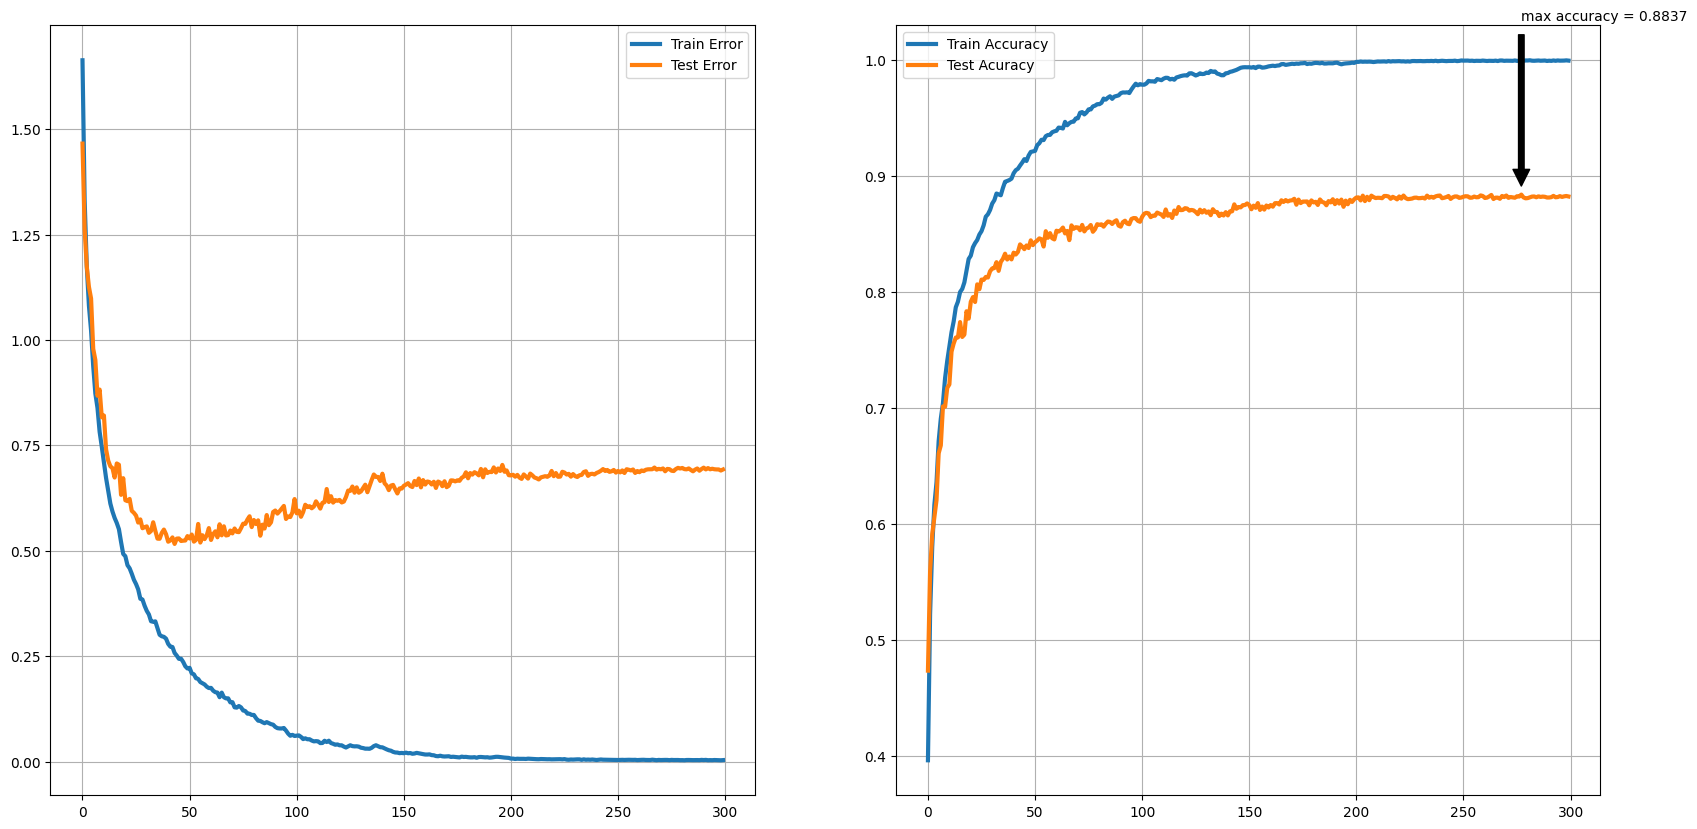

In [8]:
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(train_loss)
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
fig1.grid(True)
fig2.grid(True)
fig1.legend()
fig2.legend()
f.savefig("./trainTestCurve.png")

In [9]:
torch.save(model.state_dict(), '/content/model1.pt')